In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

train = pd.read_csv('./data/input/train.csv', parse_dates=['datetime'], index_col='datetime')
test = pd.read_csv('./data/input/test.csv', parse_dates=['datetime'], index_col='datetime')

In [2]:
def rmsle(y, y_):
    log1 = np.log(y + 1)
    log2 = np.log(y_ + 1)
    mean = np.square((log1- log2)).mean()
    return np.sqrt(mean)

In [3]:
scores_cols = ['number', 'descriptions', 'rmsle']
scores = pd.DataFrame(columns=scores_cols)

In [4]:
def add_score(number, descriptions, rmsle, scores_df, is_print=True):
    sc_df = pd.DataFrame([[number, descriptions, rmsle]], columns=scores_cols)
    for i in range(len(scores_df)):
        if scores_df.loc[:, 'number'][i] == sc_df['number'][0]:
            scores_df.drop(index=i, inplace=True)
    scores_df = pd.concat([scores_df, sc_df], axis=0, ignore_index=True)

    if is_print:
        print(scores_df.tail(10))
    return scores_df

# データ前処理

## datetime の処理

In [3]:
train['year'] = train.index.year
train['month'] = train.index.month
# train['day'] = train.index.day
train['hour'] = train.index.hour
train['weekday'] = train.index.weekday

test['year'] = test.index.year
test['month'] = test.index.month
# test['day'] = test.index.day
test['hour'] = test.index.hour
test['weekday'] = test.index.weekday

## 検証用データの作成

In [6]:
train_X, valid_X, train_y, valid_y = train_test_split(
    train.drop(columns=['registered', 'casual', 'count']),
    train.loc[:, ['registered', 'casual', 'count']],
    test_size=0.3, random_state=0)

# RF 実装
count を直接予測する．

In [7]:
model_rf = RFR(random_state=0)
model_rf.fit(train_X, train_y.loc[:, 'count'])

train_pred = model_rf.predict(train_X)
train_score = rmsle(train_y.loc[:, 'count'], train_pred)

valid_pred = model_rf.predict(valid_X)
valid_score = rmsle(valid_y.loc[:, 'count'], valid_pred)

val_score = rmsle(valid_y.loc[:, 'count'], valid_pred)
scores = add_score('00', 'Initial score', val_score, scores)

  number   descriptions     rmsle
0     00  Initial score  0.335837


# Highperparameter Tuning  
using GridSearch

In [8]:
# RF GridSearchCV
if False:
    params = [{
        'max_depth': [30],
        'min_samples_leaf': [1],
        'min_samples_split': [2],
        'n_estimators': [300, 400, 500]
    }]

    gscv = GridSearchCV(
        RFR(random_state=0, n_estimators=300, n_jobs=-1),
        param_grid=params,
        cv=5,
        verbose=2
        )

    gscv.fit(train_X, train_y.loc[:, 'count'])

In [9]:
# RF GridSearchCV check params
if False:
    print(gscv.best_params_)
    model_rf_best = gscv.best_estimator_
    model_rf_best.fit(train_X, train_y.loc[:, 'count'])
    print('train: ', model_rf_best.score(train_X, train_y.loc[:, 'count']))
    print('valid: ', model_rf_best.score(valid_X, valid_y.loc[:, 'count']))

    # results
    gscv_results = pd.DataFrame(gscv.cv_results_)
    print(gscv_results.loc[:, ['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score'))

In [10]:
model_rf_best = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
model_rf_best.fit(train_X, train_y.loc[:, 'count'])

print('train: ', model_rf_best.score(train_X, train_y.loc[:, 'count']))
print('valid: ', model_rf_best.score(valid_X, valid_y.loc[:, 'count']))

train_pred = model_rf_best.predict(train_X)
valid_pred = model_rf_best.predict(valid_X)
print('train: ', rmsle(train_y.loc[:, 'count'], train_pred))
print('valid: ', rmsle(valid_y.loc[:, 'count'], valid_pred))

train:  0.9932537088678923
valid:  0.9441567620169811
train:  0.14920487051621315
valid:  0.3354334704461627


In [11]:
def RF_Model(tr_X, tr_y, val_X, val_y):
    model = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
    model.fit(tr_X, tr_y)
    pred = model.predict(val_X)
    sc = rmsle(val_y, pred)
    return sc

In [12]:
val_score = RF_Model(train_X, train_y.loc[:, 'count'], valid_X, valid_y.loc[:, 'count'])
scores = add_score('01', 'Highperparameter Tuning', val_score, scores)

  number             descriptions     rmsle
0     00            Initial score  0.335837
1     01  Highperparameter Tuning  0.335433


# 仮説検証

## 仮説 1
count を registered と casual の和として予測する．

In [13]:
# directlly predict count
val_sc = RF_Model(train_X, train_y.loc[:, 'count'], valid_X, valid_y.loc[:, 'count'])
scores = add_score('10', 'Directly predict count', val_sc, scores)

  number             descriptions     rmsle
0     00            Initial score  0.335837
1     01  Highperparameter Tuning  0.335433
2     10   Directly predict count  0.335433


In [14]:
def RF_Model_Sum(tr_X, tr_y, val_X, val_y):
    model_r = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
    model_r.fit(tr_X, tr_y.loc[:, 'registered'])
    pred_r = model_r.predict(val_X)

    model_c = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
    model_c.fit(tr_X, tr_y.loc[:, 'casual'])
    pred_c = model_c.predict(val_X)

    pred = pred_r + pred_c
    sc = rmsle(val_y.loc[:, 'count'], pred)
    return sc

In [15]:
# predict casual and registered
sc = RF_Model_Sum(train_X, train_y, valid_X, valid_y)
scores = add_score('11', 'Sum of casual and registered', sc, scores)

  number                  descriptions     rmsle
0     00                 Initial score  0.335837
1     01       Highperparameter Tuning  0.335433
2     10        Directly predict count  0.335433
3     11  Sum of casual and registered  0.328466


## 仮説 2 : windspeed
風速 0 について

In [16]:
# do nothing
sc = RF_Model_Sum(train_X, train_y, valid_X, valid_y)
scores = add_score('20', '[windspeed] : Do nothing', sc, scores)

  number                  descriptions     rmsle
0     00                 Initial score  0.335837
1     01       Highperparameter Tuning  0.335433
2     10        Directly predict count  0.335433
3     11  Sum of casual and registered  0.328466
4     20      [windspeed] : Do nothing  0.328466


### 仮説 2-1 : delete
風速 を削除

In [17]:
sc = RF_Model_Sum(train_X.drop(columns=['windspeed'], axis=1), train_y, valid_X.drop(columns=['windspeed'], axis=1), valid_y)
scores = add_score('21', '[windspeed==0] : Deleted', sc, scores)

  number                  descriptions     rmsle
0     00                 Initial score  0.335837
1     01       Highperparameter Tuning  0.335433
2     10        Directly predict count  0.335433
3     11  Sum of casual and registered  0.328466
4     20      [windspeed] : Do nothing  0.328466
5     21      [windspeed==0] : Deleted  0.324403


### 仮説 2-2 : mean
風速 0 を平均値に置き換え

In [18]:
train_X_2_3 = train_X.copy()
train_X_2_3.replace({'windspeed': 0}, train.loc[train.loc[:, 'windspeed'] != 0, 'windspeed'].mean(), inplace=True)

valid_X_2_3 = valid_X.copy()
valid_X_2_3.replace({'windspeed': 0}, train.loc[train.loc[:, 'windspeed'] != 0, 'windspeed'].mean(), inplace=True)

sc = RF_Model_Sum(train_X_2_3, train_y, valid_X_2_3, valid_y)
scores = add_score('22', '[windspeed] : Replace with mean', sc, scores)

  number                     descriptions     rmsle
0     00                    Initial score  0.335837
1     01          Highperparameter Tuning  0.335433
2     10           Directly predict count  0.335433
3     11     Sum of casual and registered  0.328466
4     20         [windspeed] : Do nothing  0.328466
5     21         [windspeed==0] : Deleted  0.324403
6     22  [windspeed] : Replace with mean  0.328905


### 仮説 2-3 : interpolate
風速 0 を線形補完

In [19]:
train_2_3 = train.copy()
train_2_3.replace({'windspeed': 0}, np.nan, inplace=True)
train_2_3.interpolate(method='time', inplace=True, limit_direction='both')

train_X_2_3, valid_X_2_3, train_y_2, valid_y_2 = train_test_split(
    train_2_3.drop(columns=['registered', 'casual', 'count']),
    train_2_3.loc[:, ['registered', 'casual', 'count']],
    test_size=0.3, random_state=0)

In [20]:
sc = RF_Model_Sum(train_X_2_3, train_y_2, valid_X_2_3, valid_y_2)
scores = add_score('23', '[windspeed==0] : Replace by interpolate', sc, scores)

  number                             descriptions     rmsle
0     00                            Initial score  0.335837
1     01                  Highperparameter Tuning  0.335433
2     10                   Directly predict count  0.335433
3     11             Sum of casual and registered  0.328466
4     20                 [windspeed] : Do nothing  0.328466
5     21                 [windspeed==0] : Deleted  0.324403
6     22          [windspeed] : Replace with mean  0.328905
7     23  [windspeed==0] : Replace by interpolate  0.329467


### 仮説 2-4 : predict by RF

In [21]:
train_2_4 = train.copy()
model = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
model.fit(train_2_4.loc[train_2_4.loc[:, 'windspeed'] != 0, :].drop(columns=['registered', 'casual', 'count', 'windspeed'], axis=1),
          train_2_4.loc[train_2_4.loc[:, 'windspeed'] != 0, 'windspeed'])
pred = model.predict(train_2_4.loc[train_2_4.loc[:, 'windspeed'] == 0, :].drop(columns=['registered', 'casual', 'count', 'windspeed'], axis=1))

train_2_4.loc[train_2_4.loc[:, 'windspeed'] == 0, 'windspeed'] = pred

train_X_2_4, valid_X_2_4, train_y_2, valid_y_2 = train_test_split(
    train_2_4.drop(columns=['registered', 'casual', 'count']),
    train_2_4.loc[:, ['registered', 'casual', 'count']],
    test_size=0.3, random_state=0)

In [22]:
sc = RF_Model_Sum(train_X_2_4, train_y_2, valid_X_2_4, valid_y_2)
scores = add_score('24', '[windspeed==0] : Replace by RF', sc, scores)

  number                             descriptions     rmsle
0     00                            Initial score  0.335837
1     01                  Highperparameter Tuning  0.335433
2     10                   Directly predict count  0.335433
3     11             Sum of casual and registered  0.328466
4     20                 [windspeed] : Do nothing  0.328466
5     21                 [windspeed==0] : Deleted  0.324403
6     22          [windspeed] : Replace with mean  0.328905
7     23  [windspeed==0] : Replace by interpolate  0.329467
8     24           [windspeed==0] : Replace by RF  0.330366


## 仮説 3 : weather
天候 4 を 3 とする．  
仮説 1, 仮説 2-1 の手法を用いる．

In [23]:
sc = RF_Model_Sum(train_X.drop(columns=['windspeed'], axis=1), train_y, valid_X.drop(columns=['windspeed'], axis=1), valid_y)
scores = add_score('30', '[weather] : Do nothing', sc, scores)

  number                             descriptions     rmsle
0     00                            Initial score  0.335837
1     01                  Highperparameter Tuning  0.335433
2     10                   Directly predict count  0.335433
3     11             Sum of casual and registered  0.328466
4     20                 [windspeed] : Do nothing  0.328466
5     21                 [windspeed==0] : Deleted  0.324403
6     22          [windspeed] : Replace with mean  0.328905
7     23  [windspeed==0] : Replace by interpolate  0.329467
8     24           [windspeed==0] : Replace by RF  0.330366
9     30                   [weather] : Do nothing  0.324403


In [24]:
train_X_3 = train_X.replace({'weather': 4}, 3).drop(columns=['windspeed'], axis=1)
valid_X_3 = valid_X.replace({'weather': 4}, 3).drop(columns=['windspeed'], axis=1)

In [25]:
sc = RF_Model_Sum(train_X_3, train_y, valid_X_3, valid_y)
scores = add_score('31', '[weather==4] : Replace with 3', sc, scores)

   number                             descriptions     rmsle
1      01                  Highperparameter Tuning  0.335433
2      10                   Directly predict count  0.335433
3      11             Sum of casual and registered  0.328466
4      20                 [windspeed] : Do nothing  0.328466
5      21                 [windspeed==0] : Deleted  0.324403
6      22          [windspeed] : Replace with mean  0.328905
7      23  [windspeed==0] : Replace by interpolate  0.329467
8      24           [windspeed==0] : Replace by RF  0.330366
9      30                   [weather] : Do nothing  0.324403
10     31            [weather==4] : Replace with 3  0.324384


## 仮説 4 : atemp
atemp を使用しない．  
仮説 3 の下で行う．

In [26]:
# Do nothing
sc = RF_Model_Sum(train_X_3, train_y_2, valid_X_3, valid_y_2)
scores = add_score('40', '[atemp] : Do nothing', sc, scores)

   number                             descriptions     rmsle
2      10                   Directly predict count  0.335433
3      11             Sum of casual and registered  0.328466
4      20                 [windspeed] : Do nothing  0.328466
5      21                 [windspeed==0] : Deleted  0.324403
6      22          [windspeed] : Replace with mean  0.328905
7      23  [windspeed==0] : Replace by interpolate  0.329467
8      24           [windspeed==0] : Replace by RF  0.330366
9      30                   [weather] : Do nothing  0.324403
10     31            [weather==4] : Replace with 3  0.324384
11     40                     [atemp] : Do nothing  0.324384


In [27]:
# Delete atemp
sc = RF_Model_Sum(train_X_3.drop(columns=['atemp'], axis=1), train_y, valid_X_3.drop(columns=['atemp'], axis=1), valid_y)
scores = add_score('41', '[atemp] : Deleted', sc, scores)

   number                             descriptions     rmsle
3      11             Sum of casual and registered  0.328466
4      20                 [windspeed] : Do nothing  0.328466
5      21                 [windspeed==0] : Deleted  0.324403
6      22          [windspeed] : Replace with mean  0.328905
7      23  [windspeed==0] : Replace by interpolate  0.329467
8      24           [windspeed==0] : Replace by RF  0.330366
9      30                   [weather] : Do nothing  0.324403
10     31            [weather==4] : Replace with 3  0.324384
11     40                     [atemp] : Do nothing  0.324384
12     41                        [atemp] : Deleted  0.325791


## 仮説 5 : log
目的変数を対数変換する．log(x + 1)  
仮説 3 の下で行う．

In [28]:
# Do nothing
sc = RF_Model_Sum(train_X_3, train_y, valid_X_3, valid_y)
scores = add_score('50', '[registered, casual] : Do nothing', sc, scores)

   number                             descriptions     rmsle
4      20                 [windspeed] : Do nothing  0.328466
5      21                 [windspeed==0] : Deleted  0.324403
6      22          [windspeed] : Replace with mean  0.328905
7      23  [windspeed==0] : Replace by interpolate  0.329467
8      24           [windspeed==0] : Replace by RF  0.330366
9      30                   [weather] : Do nothing  0.324403
10     31            [weather==4] : Replace with 3  0.324384
11     40                     [atemp] : Do nothing  0.324384
12     41                        [atemp] : Deleted  0.325791
13     50        [registered, casual] : Do nothing  0.324384


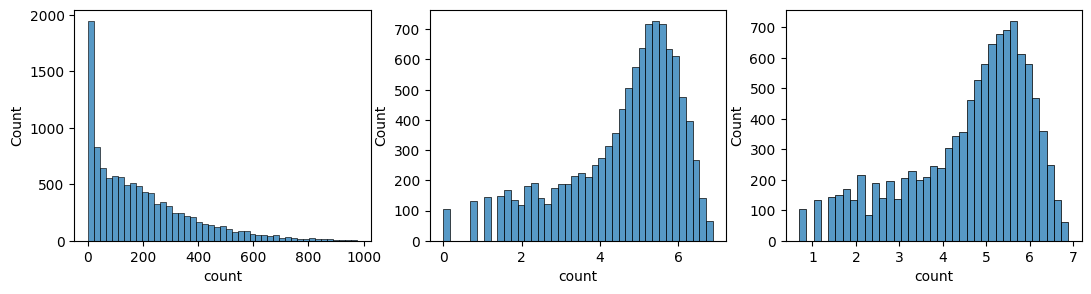

In [29]:
# 自然対数
fig, axes = plt.subplots(1, 3, figsize=(13, 3))
sns.histplot(train['count'], ax=axes[0])
sns.histplot(np.log(train['count']), ax=axes[1])
sns.histplot(np.log1p(train['count']), ax=axes[2])
plt.show()

In [30]:
def RF_Model_Sum_Logex(tr_X, tr_y, val_X, val_y):
    model_r = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
    model_r.fit(tr_X, np.log1p(tr_y.loc[:, 'registered']))
    pred_r = model_r.predict(val_X)

    model_c = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
    model_c.fit(tr_X, np.log1p(tr_y.loc[:, 'casual']))
    pred_c = model_c.predict(val_X)

    pred = np.expm1(pred_r) + np.expm1(pred_c)
    sc = rmsle(val_y.loc[:, 'count'], pred)
    return sc

In [31]:
sc = RF_Model_Sum_Logex(train_X_3, train_y, valid_X_3, valid_y)
scores = add_score('51', '[registered, casual] : Log', sc, scores)

   number                             descriptions     rmsle
5      21                 [windspeed==0] : Deleted  0.324403
6      22          [windspeed] : Replace with mean  0.328905
7      23  [windspeed==0] : Replace by interpolate  0.329467
8      24           [windspeed==0] : Replace by RF  0.330366
9      30                   [weather] : Do nothing  0.324403
10     31            [weather==4] : Replace with 3  0.324384
11     40                     [atemp] : Do nothing  0.324384
12     41                        [atemp] : Deleted  0.325791
13     50        [registered, casual] : Do nothing  0.324384
14     51               [registered, casual] : Log  0.302610


## 仮説 6 : scaler
連続変数を標準化する．  
仮説 5 の下で行う．

In [32]:
# Do nothing
sc = RF_Model_Sum_Logex(train_X_3, train_y, valid_X_3, valid_y)
scores = add_score('60', 'Do nothing', sc, scores)

   number                             descriptions     rmsle
6      22          [windspeed] : Replace with mean  0.328905
7      23  [windspeed==0] : Replace by interpolate  0.329467
8      24           [windspeed==0] : Replace by RF  0.330366
9      30                   [weather] : Do nothing  0.324403
10     31            [weather==4] : Replace with 3  0.324384
11     40                     [atemp] : Do nothing  0.324384
12     41                        [atemp] : Deleted  0.325791
13     50        [registered, casual] : Do nothing  0.324384
14     51               [registered, casual] : Log  0.302610
15     60                               Do nothing  0.302610


In [33]:
numerical_cols = ['temp', 'atemp', 'humidity']  # windspeed has been already deleted
train_X_6 = train_X_3.copy()
valid_X_6 = valid_X_3.copy()

scaler = StandardScaler()
scaler.fit(pd.concat([train_X_6.loc[:, numerical_cols], valid_X_6.loc[:, numerical_cols]], axis=0))
train_X_6.loc[:, numerical_cols] = scaler.transform(train_X_6.loc[:, numerical_cols])
valid_X_6.loc[:, numerical_cols] = scaler.transform(valid_X_6.loc[:, numerical_cols])

sc = RF_Model_Sum_Logex(train_X_6, train_y, valid_X_6, valid_y)
scores = add_score('61', 'StandardScaler', sc, scores)

   number                             descriptions     rmsle
7      23  [windspeed==0] : Replace by interpolate  0.329467
8      24           [windspeed==0] : Replace by RF  0.330366
9      30                   [weather] : Do nothing  0.324403
10     31            [weather==4] : Replace with 3  0.324384
11     40                     [atemp] : Do nothing  0.324384
12     41                        [atemp] : Deleted  0.325791
13     50        [registered, casual] : Do nothing  0.324384
14     51               [registered, casual] : Log  0.302610
15     60                               Do nothing  0.302610
16     61                           StandardScaler  0.302298


In [34]:
train_X_6.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'year', 'month', 'hour', 'weekday'],
      dtype='object')

## 仮説 7 : datetime
datetime について  
仮説 6 の下で行う

In [35]:
# Do nothing
sc = RF_Model_Sum_Logex(train_X_6, train_y, valid_X_6, valid_y)
scores = add_score('70', '[datetime] : Do nothing', sc, scores)

   number                       descriptions     rmsle
8      24     [windspeed==0] : Replace by RF  0.330366
9      30             [weather] : Do nothing  0.324403
10     31      [weather==4] : Replace with 3  0.324384
11     40               [atemp] : Do nothing  0.324384
12     41                  [atemp] : Deleted  0.325791
13     50  [registered, casual] : Do nothing  0.324384
14     51         [registered, casual] : Log  0.302610
15     60                         Do nothing  0.302610
16     61                     StandardScaler  0.302298
17     70            [datetime] : Do nothing  0.302298


### 仮説 7-1 : month

In [36]:
print('The months of season 1: ', set(train_X_6.loc[train_X_6.loc[:, 'season'] == 1, 'month'].values))
print('The months of season 2: ', set(train_X_6.loc[train_X_6.loc[:, 'season'] == 2, 'month'].values))
print('The months of season 3: ', set(train_X_6.loc[train_X_6.loc[:, 'season'] == 3, 'month'].values))
print('The months of season 4: ', set(train_X_6.loc[train_X_6.loc[:, 'season'] == 4, 'month'].values))

The months of season 1:  {1, 2, 3}
The months of season 2:  {4, 5, 6}
The months of season 3:  {8, 9, 7}
The months of season 4:  {10, 11, 12}


In [37]:
# delete month
sc = RF_Model_Sum_Logex(train_X_6.drop(columns=['month'], axis=1), train_y, valid_X_6.drop(columns=['month'], axis=1), valid_y)
scores = add_score('71', '[month] : Deleted', sc, scores)

   number                       descriptions     rmsle
9      30             [weather] : Do nothing  0.324403
10     31      [weather==4] : Replace with 3  0.324384
11     40               [atemp] : Do nothing  0.324384
12     41                  [atemp] : Deleted  0.325791
13     50  [registered, casual] : Do nothing  0.324384
14     51         [registered, casual] : Log  0.302610
15     60                         Do nothing  0.302610
16     61                     StandardScaler  0.302298
17     70            [datetime] : Do nothing  0.302298
18     71                  [month] : Deleted  0.310272


### 仮説 7-2 : season

In [38]:
# delete season
sc = RF_Model_Sum_Logex(train_X_6.drop(columns=['season'], axis=1), train_y, valid_X_6.drop(columns=['season'], axis=1), valid_y)
scores = add_score('72', '[season] : Deleted', sc, scores)

   number                       descriptions     rmsle
10     31      [weather==4] : Replace with 3  0.324384
11     40               [atemp] : Do nothing  0.324384
12     41                  [atemp] : Deleted  0.325791
13     50  [registered, casual] : Do nothing  0.324384
14     51         [registered, casual] : Log  0.302610
15     60                         Do nothing  0.302610
16     61                     StandardScaler  0.302298
17     70            [datetime] : Do nothing  0.302298
18     71                  [month] : Deleted  0.310272
19     72                 [season] : Deleted  0.302249


### 仮説 7-3 : weekday

In [39]:
# Delete weekday
sc = RF_Model_Sum_Logex(train_X_6.drop(columns=['weekday'], axis=1), train_y, valid_X_6.drop(columns=['weekday'], axis=1), valid_y)
scores = add_score('73', '[weekday] : deleted', sc, scores)

   number                       descriptions     rmsle
11     40               [atemp] : Do nothing  0.324384
12     41                  [atemp] : Deleted  0.325791
13     50  [registered, casual] : Do nothing  0.324384
14     51         [registered, casual] : Log  0.302610
15     60                         Do nothing  0.302610
16     61                     StandardScaler  0.302298
17     70            [datetime] : Do nothing  0.302298
18     71                  [month] : Deleted  0.310272
19     72                 [season] : Deleted  0.302249
20     73                [weekday] : deleted  0.326193


### 仮説 7-4 : day

In [40]:
# Add day
train_X_6_day = pd.DataFrame(train_X_6.index.day, index=train_X_6.index).rename(columns={'datetime': 'day'})
valid_X_6_day = pd.DataFrame(valid_X_6.index.day, index=valid_X_6.index).rename(columns={'datetime': 'day'})

In [41]:
sc = RF_Model_Sum_Logex(
    pd.concat([train_X_6, train_X_6_day], axis=1),
    train_y,
    pd.concat([valid_X_6, valid_X_6_day], axis=1),
    valid_y
)
scores = add_score('74', '[day] : Added', sc, scores)

   number                       descriptions     rmsle
12     41                  [atemp] : Deleted  0.325791
13     50  [registered, casual] : Do nothing  0.324384
14     51         [registered, casual] : Log  0.302610
15     60                         Do nothing  0.302610
16     61                     StandardScaler  0.302298
17     70            [datetime] : Do nothing  0.302298
18     71                  [month] : Deleted  0.310272
19     72                 [season] : Deleted  0.302249
20     73                [weekday] : deleted  0.326193
21     74                      [day] : Added  0.300317


## 仮説 8 : datetime, SIO

In [42]:
# saparate in order
train_8 = pd.concat([pd.concat([train_X_6, train_y], axis=1), pd.concat([valid_X_6, valid_y], axis=1)], axis=0).sort_index()

train_X_8 = train_8.loc[train_8.index.day <= 14, :].drop(columns=train_y.columns)
valid_X_8 = train_8.loc[train_8.index.day > 14, :].drop(columns=train_y.columns)

train_y_8 = train_8.loc[train_X_8.index, train_y.columns]
valid_y_8 = train_8.loc[valid_X_8.index, train_y.columns]

In [43]:
print(train_X_6.shape, train_X_8.shape)

(7620, 11) (8026, 11)


In [44]:
sc = RF_Model_Sum_Logex(train_X_8, train_y_8, valid_X_8, valid_y_8)
scores = add_score('80', 'separate in order, sorted', sc, scores, False)

In [45]:
# shuffle
shuffle_index = np.random.permutation(train_X_8.index)
sc = RF_Model_Sum_Logex(train_X_8.loc[shuffle_index, :], train_y_8.loc[shuffle_index, :], valid_X_8, valid_y_8)
scores = add_score('81', 'separate in order, shuffle', sc, scores)

   number                descriptions     rmsle
14     51  [registered, casual] : Log  0.302610
15     60                  Do nothing  0.302610
16     61              StandardScaler  0.302298
17     70     [datetime] : Do nothing  0.302298
18     71           [month] : Deleted  0.310272
19     72          [season] : Deleted  0.302249
20     73         [weekday] : deleted  0.326193
21     74               [day] : Added  0.300317
22     80   separate in order, sorted  0.320048
23     81  separate in order, shuffle  0.320231


In [46]:
# SIO sorted, delete month
sc = RF_Model_Sum_Logex(train_X_8.drop(columns=['month'], axis=1), train_y_8, valid_X_8.drop(columns=['month'], axis=1), valid_y_8)
scores = add_score('82', 'SIO sorted, [month] : deleted', sc, scores, False)

#SIO sorted, delete season
sc = RF_Model_Sum_Logex(train_X_8.drop(columns=['season'], axis=1), train_y_8, valid_X_8.drop(columns=['season'], axis=1), valid_y_8)
scores = add_score('83', 'SIO sorted, [season] : deleted', sc, scores, False)

# SIO sorted, delete weekday
sc = RF_Model_Sum_Logex(train_X_8.drop(columns=['weekday'], axis=1), train_y_8, valid_X_8.drop(columns=['weekday'], axis=1), valid_y_8)
scores = add_score('84', 'SIO sorted, [weekday] : deleted', sc, scores)

   number                     descriptions     rmsle
17     70          [datetime] : Do nothing  0.302298
18     71                [month] : Deleted  0.310272
19     72               [season] : Deleted  0.302249
20     73              [weekday] : deleted  0.326193
21     74                    [day] : Added  0.300317
22     80        separate in order, sorted  0.320048
23     81       separate in order, shuffle  0.320231
24     82    SIO sorted, [month] : deleted  0.342248
25     83   SIO sorted, [season] : deleted  0.319927
26     84  SIO sorted, [weekday] : deleted  0.350749


In [47]:
# SIO sorted, add day
train_X_8_day = pd.DataFrame(train_X_8.index.day, index=train_X_8.index).rename(columns={'datetime': 'day'})
valid_X_8_day = pd.DataFrame(valid_X_8.index.day, index=valid_X_8.index).rename(columns={'datetime': 'day'})

sc = RF_Model_Sum_Logex(
    pd.concat([train_X_8, train_X_8_day], axis=1),
    train_y_8,
    pd.concat([valid_X_8, valid_X_8_day], axis=1),
    valid_y_8
)
scores = add_score('85', 'SIO sorted, [day] : Added', sc, scores, False)

# SIO shuffle, add day
sc = RF_Model_Sum_Logex(
    pd.concat([train_X_8, train_X_8_day], axis=1).loc[shuffle_index, :],
    train_y_8.loc[shuffle_index, :],
    pd.concat([valid_X_8, valid_X_8_day], axis=1),
    valid_y_8
)
scores = add_score('86', 'SIO shuffle, [day] : Added', sc, scores)

   number                     descriptions     rmsle
19     72               [season] : Deleted  0.302249
20     73              [weekday] : deleted  0.326193
21     74                    [day] : Added  0.300317
22     80        separate in order, sorted  0.320048
23     81       separate in order, shuffle  0.320231
24     82    SIO sorted, [month] : deleted  0.342248
25     83   SIO sorted, [season] : deleted  0.319927
26     84  SIO sorted, [weekday] : deleted  0.350749
27     85        SIO sorted, [day] : Added  0.319094
28     86       SIO shuffle, [day] : Added  0.318503


## 仮説 9 : humidity

In [48]:
# check the number of zero in humidity
print('The number of zero in humidity: ', train.loc[train.loc[:, 'humidity'] == 0, 'humidity'].shape[0])

The number of zero in humidity:  22


In [49]:
train_X_9 = pd.concat([train_X_8, train_X_8_day], axis=1).sample(frac=1, random_state=0)
valid_X_9 = pd.concat([valid_X_8, valid_X_8_day], axis=1)

train_y_9 = train_y_8.loc[train_X_9.index, :]
valid_y_9 = valid_y_8.loc[valid_X_9.index, :]

In [50]:
# Do nothing
sc = RF_Model_Sum_Logex(train_X_9, train_y_9, valid_X_9, valid_y_9)
scores = add_score('90', '[humidity] : Do nothing', sc, scores)

   number                     descriptions     rmsle
20     73              [weekday] : deleted  0.326193
21     74                    [day] : Added  0.300317
22     80        separate in order, sorted  0.320048
23     81       separate in order, shuffle  0.320231
24     82    SIO sorted, [month] : deleted  0.342248
25     83   SIO sorted, [season] : deleted  0.319927
26     84  SIO sorted, [weekday] : deleted  0.350749
27     85        SIO sorted, [day] : Added  0.319094
28     86       SIO shuffle, [day] : Added  0.318503
29     90          [humidity] : Do nothing  0.319291


### 仮説 9-1 : delete

In [51]:
# Delete humidity
sc = RF_Model_Sum_Logex(train_X_9.drop(columns=['humidity'], axis=1), train_y_9, valid_X_9.drop(columns=['humidity'], axis=1), valid_y_9)
scores = add_score('91', '[humidity] : Deleted', sc, scores, False)

### 仮説 9-2: mean

In [52]:
train_9_2 = train.copy()
train_9_2.drop(columns=['season', 'windspeed'], axis=1)
train_9_2.replace({'weather': 4}, 3).replace({'humidity': 0}, train_9_2.loc[train_9_2.loc[:, 'humidity'] != 0, 'humidity'].mean(), inplace=True)
train_9_2.loc[:, 'day'] = train_9_2.index.day

scaler = StandardScaler()
train_9_2.loc[:, ['temp', 'atemp', 'humidity']] = scaler.fit_transform(train_9_2.loc[:, ['temp', 'atemp', 'humidity']])

train_X_9_2 = train_9_2.loc[train_X_9.index, train_X_9.columns]
valid_X_9_2 = train_9_2.loc[valid_X_9.index, train_X_9.columns]

In [53]:
# Replace zero with mean
sc = RF_Model_Sum_Logex(train_X_9_2, train_y_9, valid_X_9_2, valid_y_9)
scores = add_score('92', '[humidity] : Replaced zero with mean', sc, scores)

   number                          descriptions     rmsle
22     80             separate in order, sorted  0.320048
23     81            separate in order, shuffle  0.320231
24     82         SIO sorted, [month] : deleted  0.342248
25     83        SIO sorted, [season] : deleted  0.319927
26     84       SIO sorted, [weekday] : deleted  0.350749
27     85             SIO sorted, [day] : Added  0.319094
28     86            SIO shuffle, [day] : Added  0.318503
29     90               [humidity] : Do nothing  0.319291
30     91                  [humidity] : Deleted  0.333830
31     92  [humidity] : Replaced zero with mean  0.319134


### 仮説 9-3 : interpolate

In [54]:
train_9_3 = train.copy()
train_9_3.drop(columns=['season', 'windspeed'], axis=1)
train_9_3.replace({'weather': 4}, 3).replace({'humidity': 0}, np.nan, inplace=True)
train_9_3.interpolate(method='time', inplace=True, limit_direction='both')
train_9_3.loc[:, 'day'] = train_9_3.index.day

train_X_9_3 = train_9_3.loc[train_X_9.index, train_X_9.columns]
valid_X_9_3 = train_9_3.loc[valid_X_9.index, train_X_9.columns]

In [55]:
sc = RF_Model_Sum_Logex(train_X_9_3, train_y_9, valid_X_9_3, valid_y_9)
scores = add_score('93', '[humidity] : Replaced zero with interpolate', sc, scores)

   number                                 descriptions     rmsle
23     81                   separate in order, shuffle  0.320231
24     82                SIO sorted, [month] : deleted  0.342248
25     83               SIO sorted, [season] : deleted  0.319927
26     84              SIO sorted, [weekday] : deleted  0.350749
27     85                    SIO sorted, [day] : Added  0.319094
28     86                   SIO shuffle, [day] : Added  0.318503
29     90                      [humidity] : Do nothing  0.319291
30     91                         [humidity] : Deleted  0.333830
31     92         [humidity] : Replaced zero with mean  0.319134
32     93  [humidity] : Replaced zero with interpolate  0.319005


### 仮説 9-4 : RF

In [56]:
train_9_4 = train_9_3.copy()
train_9_4.loc[:, 'humidity'] = train.loc[train_9_4.index, 'humidity']

model = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
model.fit(train_9_4.loc[train_9_4.loc[:, 'humidity'] != 0, :].drop(columns=['registered', 'casual', 'count', 'humidity'], axis=1),
            train_9_4.loc[train_9_4.loc[:, 'humidity'] != 0, 'humidity'])
pred = model.predict(train_9_4.loc[train_9_4.loc[:, 'humidity'] == 0, :].drop(columns=['registered', 'casual', 'count', 'humidity'], axis=1))

train_9_4.loc[train_9_4.loc[:, 'humidity'] == 0, 'humidity'] = pred

scaler = StandardScaler()
train_9_4.loc[:, 'humidity'] = scaler.fit_transform(train_9_4.loc[:, ['humidity']])

train_X_9_4 = train_9_4.loc[train_X_9.index, train_X_9.columns]
valid_X_9_4 = train_9_4.loc[valid_X_9.index, train_X_9.columns]

In [57]:
sc = RF_Model_Sum_Logex(train_X_9_4, train_y_9, valid_X_9_4, valid_y_9)
scores = add_score('94', '[humidity] : Replaced zero with RF', sc, scores)

   number                                 descriptions     rmsle
24     82                SIO sorted, [month] : deleted  0.342248
25     83               SIO sorted, [season] : deleted  0.319927
26     84              SIO sorted, [weekday] : deleted  0.350749
27     85                    SIO sorted, [day] : Added  0.319094
28     86                   SIO shuffle, [day] : Added  0.318503
29     90                      [humidity] : Do nothing  0.319291
30     91                         [humidity] : Deleted  0.333830
31     92         [humidity] : Replaced zero with mean  0.319134
32     93  [humidity] : Replaced zero with interpolate  0.319005
33     94           [humidity] : Replaced zero with RF  0.320194


# 提出

In [58]:
print(train.columns.values)
print(test.columns.values)

['season' 'holiday' 'workingday' 'weather' 'temp' 'atemp' 'humidity'
 'windspeed' 'casual' 'registered' 'count' 'year' 'month' 'hour' 'weekday']
['season' 'holiday' 'workingday' 'weather' 'temp' 'atemp' 'humidity'
 'windspeed' 'year' 'month' 'hour' 'weekday']


## Submission 1
- predict count by sum of registered and casual
- log convertion and scaler
- datetime: year, month, day, weekday
- delete: windspeed, season
- weather: 4 -> 3
- humidity: interpolate

In [4]:
data_s_1 = pd.concat([train, test], axis=0)
data_s_1.loc[:, 'day'] = data_s_1.index.day
data_s_1.drop(columns=['season', 'windspeed'], axis=1, inplace=True)
data_s_1.replace({'weather': 4}, 3).replace({'humidity': 0}, np.nan, inplace=True)
data_s_1.interpolate(method='time', inplace=True, limit_direction='both')

numerical_cols = ['temp', 'atemp', 'humidity']
scaler = StandardScaler()
data_s_1.loc[:, numerical_cols] = scaler.fit_transform(data_s_1.loc[:, numerical_cols])

train_s_1 = data_s_1.loc[train.index, :]
train_s_1.loc[:, 'registered'] = np.log1p(train_s_1.loc[:, 'registered'])
train_s_1.loc[:, 'casual'] = np.log1p(train_s_1.loc[:, 'casual'])

test_s_1 = data_s_1.loc[test.index, :].drop(columns=['registered', 'casual', 'count'], axis=1)

In [60]:
rf_r = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
rf_r.fit(train_s_1.drop(columns=['registered', 'casual', 'count'], axis=1), train_s_1.loc[:, 'registered'])
pred_r = rf_r.predict(test_s_1)

rf_c = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
rf_c.fit(train_s_1.drop(columns=['registered', 'casual', 'count'], axis=1), train_s_1.loc[:, 'casual'])
pred_c = rf_c.predict(test_s_1)

pred = np.expm1(pred_r) + np.expm1(pred_c)

In [61]:
submission = pd.DataFrame({'datetime': test.index, 'count': pred})
submission.to_csv('./data/output/submission_s_1.csv', index=False)

## Submission 2
**1->deleted day**
- predict count by sum of registered and casual
- log convertion and scaler
- datetime: year, month, weekday
- delete: windspeed, season
- weather: 4 -> 3
- humidity: interpolate

In [5]:
train_s_2 = train_s_1.drop(columns=['day'], axis=1)
test_s_2 = test_s_1.drop(columns=['day'], axis=1)

In [63]:
rf_r = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
rf_r.fit(train_s_2.drop(columns=['registered', 'casual', 'count'], axis=1), train_s_2.loc[:, 'registered'])
pred_r = rf_r.predict(test_s_2)

rf_c = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
rf_c.fit(train_s_2.drop(columns=['registered', 'casual', 'count'], axis=1), train_s_2.loc[:, 'casual'])
pred_c = rf_c.predict(test_s_2)

pred = np.expm1(pred_r) + np.expm1(pred_c)

In [64]:
submission = pd.DataFrame({'datetime': test.index, 'count': pred})
submission.to_csv('./data/output/submission_s_2.csv', index=False)

## Submission 3
**2->using windspeed interpolated**
- predict count by sum of registered and casual
- log convertion and scaler
- datetime: year, month, weekday
- delete: season
- weather: 4 -> 3
- humidity, windspeed: interpolate

In [6]:
train_s_3 = train_s_2.copy()
test_s_3 = test_s_2.copy()

wind = pd.DataFrame(pd.concat([train.loc[:, 'windspeed'], test.loc[:, 'windspeed']], axis=0), columns=['windspeed'])
wind.replace({'windspeed': 0}, np.nan, inplace=True)
wind.interpolate(method='time', inplace=True, limit_direction='both')

scaler = StandardScaler()
wind.loc[:, 'windspeed'] = scaler.fit_transform(wind.loc[:, ['windspeed']])

train_s_3.loc[:, 'windspeed'] = wind.loc[train_s_3.index]
test_s_3.loc[:, 'windspeed'] = wind.loc[test_s_3.index]

In [73]:
rf_r = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
rf_r.fit(train_s_3.drop(columns=['registered', 'casual', 'count'], axis=1), train_s_3.loc[:, 'registered'])
pred_r = rf_r.predict(test_s_3)

rf_c = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
rf_c.fit(train_s_3.drop(columns=['registered', 'casual', 'count'], axis=1), train_s_3.loc[:, 'casual'])
pred_c = rf_c.predict(test_s_3)

pred = np.expm1(pred_r) + np.expm1(pred_c)

In [74]:
submission = pd.DataFrame({'datetime': test.index, 'count': pred})
submission.to_csv('./data/output/submission_s_3.csv', index=False)

: 

## Submission 4
**3->wind, humidity: no convertion**
- predict count by sum of registered and casual
- log convertion and scaler
- datetime: year, month, weekday
- delete: season
- weather: 4 -> 3

In [7]:
train_s_4 = train_s_3.copy()
test_s_4 = test_s_3.copy()

train_s_4.loc[:, 'windspeed'] = train.loc[:, 'windspeed']
train_s_4.loc[:, 'humidity'] = train.loc[:, 'humidity']
test_s_4.loc[:, 'windspeed'] = test.loc[:, 'windspeed']
test_s_4.loc[:, 'humidity'] = test.loc[:, 'humidity']

scaler = StandardScaler()
train_s_4.loc[:, ['windspeed', 'humidity']] = scaler.fit_transform(train_s_4.loc[:, ['windspeed', 'humidity']])
test_s_4.loc[:, ['windspeed', 'humidity']] = scaler.transform(test_s_4.loc[:, ['windspeed', 'humidity']])

In [8]:
rf_r = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
rf_r.fit(train_s_4.drop(columns=['registered', 'casual', 'count'], axis=1), train_s_4.loc[:, 'registered'])
pred_r = rf_r.predict(test_s_4)

rf_c = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
rf_c.fit(train_s_4.drop(columns=['registered', 'casual', 'count'], axis=1), train_s_4.loc[:, 'casual'])
pred_c = rf_c.predict(test_s_4)

pred = np.expm1(pred_r) + np.expm1(pred_c)

In [9]:
submission = pd.DataFrame({'datetime': test.index, 'count': pred})
submission.to_csv('./data/output/submission_s_4.csv', index=False)

## Submission 5
**3->atemp: delete**
- predict count by sum of registered and casual
- log convertion and scaler
- datetime: year, month, weekday
- delete: season, atemp
- weather: 4 -> 3
- humidity, windspeed: interpolate

In [10]:
train_s_5 = train_s_3.copy()
test_s_5 = test_s_3.copy()

train_s_5.drop(columns=['atemp'], axis=1, inplace=True)
test_s_5.drop(columns=['atemp'], axis=1, inplace=True)

In [11]:
rf_r = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
rf_r.fit(train_s_5.drop(columns=['registered', 'casual', 'count'], axis=1), train_s_5.loc[:, 'registered'])
pred_r = rf_r.predict(test_s_5)

rf_c = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
rf_c.fit(train_s_5.drop(columns=['registered', 'casual', 'count'], axis=1), train_s_5.loc[:, 'casual'])
pred_c = rf_c.predict(test_s_5)

pred = np.expm1(pred_r) + np.expm1(pred_c)

In [12]:
submission = pd.DataFrame({'datetime': test.index, 'count': pred})
submission.to_csv('./data/output/submission_s_5.csv', index=False)